# Example with high-resolution CMIP6 models (~100 km) using Pangeo catalog 

### Time period

We will use data from 1985 to 2014.

### Variables 

| shortname     |             Long name                   |      Units    |  levels |
| ------------- |:---------------------------------------:| -------------:|--------:|
|  prsn         |    Snowfall Flux                        | [kg m-2 s-1]  | surface |
| clw           |    Mass Fraction of Cloud Liquid Water  |  [kg kg-1]    |    ml   |
| cli           |    Mass Fraction of Cloud Ice           | [kg kg-1]     |    ml   |
| tas           |    Near-Surface Air Temperature         |   [K]         | surface |
| ta            |    Air Temperature                      |  [K]          |    ml   |
| clivi         |    Ice Water Path                       | [kg m-2]      |         |
| lwp           |    Liquid Water Path                    | [kg m-2]      |         |
| pr            |    Precipitation                        | [kg m-2 s-1]  | surface |


## Import python packages

In [1]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
import sys
sys.path.append('/uio/kant/geo-metos-u1/franzihe/Documents/Python/globalsnow/eosc-nordic-climate-demonstrator/work/utils')
from imports import (xr, intake, cftime,  xe, glob, np, cm, pd, fct,ccrs, cy, plt,)

xr.set_options(display_style="html")

# %matplotlib inline


# reload imports
%load_ext autoreload
%autoreload 2

### Open CMIP6 online catalog

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,709
grid_label,10
zstore,522489
dcpp_init_year,60


### Search corresponding data

In [3]:
list_models = [
    'NorESM2-MM',
    'TaiESM1',
    'EC-Earth3-AerChem',
    'GFDL-ESM4',
    'SAM0-UNICON',
    'CAMS-CSM1-0',
    'CMCC-CM2-HR4',
    'MPI-ESM1-2-HR',
    'BCC-CSM2-MR',
    'E3SM-1-1',
    'CMCC-CM2-SR5',
    'CMCC-ESM2',
    'FGOALS-f3-L',
    'E3SM-1-1-ECA',
    'CIESM',
    'GFDL-CM4',
    'MRI-ESM2-0']  

In [4]:
variable_id=[
            #  'prsn', 
            #  'clivi',
            # 'lwp',
            # 'tas',
            # 'pr',
            'clw'

             ]
cat = col.search(source_id=list_models, table_id = ['Amon', 'AERmon'], experiment_id=['historical'], variable_id=variable_id[0], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Amon,clw,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
1,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Amon,clw,gn,gs://cmip6/CMIP6/CMIP/BCC/BCC-CSM2-MR/historic...,NaN,20181126
2,CMIP,MRI,MRI-ESM2-0,historical,r1i1p1f1,Amon,clw,gn,gs://cmip6/CMIP6/CMIP/MRI/MRI-ESM2-0/historica...,NaN,20190308
3,CMIP,SNU,SAM0-UNICON,historical,r1i1p1f1,Amon,clw,gn,gs://cmip6/CMIP6/CMIP/SNU/SAM0-UNICON/historic...,NaN,20190323
4,CMIP,CAMS,CAMS-CSM1-0,historical,r1i1p1f1,Amon,clw,gn,gs://cmip6/CMIP6/CMIP/CAMS/CAMS-CSM1-0/histori...,NaN,20190708
5,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Amon,clw,gn,gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/hist...,NaN,20190710
6,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Amon,clw,gr1,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...,NaN,20190726
7,CMIP,CAS,FGOALS-f3-L,historical,r1i1p1f1,Amon,clw,gr,gs://cmip6/CMIP6/CMIP/CAS/FGOALS-f3-L/historic...,NaN,20190927
8,CMIP,NCC,NorESM2-MM,historical,r1i1p1f1,Amon,clw,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-MM/historica...,NaN,20191108
9,CMIP,E3SM-Project,E3SM-1-1,historical,r1i1p1f1,Amon,clw,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-1/hi...,NaN,20191211


In [5]:
cat.df['source_id'].unique()

array(['GFDL-CM4', 'BCC-CSM2-MR', 'MRI-ESM2-0', 'SAM0-UNICON',
       'CAMS-CSM1-0', 'MPI-ESM1-2-HR', 'GFDL-ESM4', 'FGOALS-f3-L',
       'NorESM2-MM', 'E3SM-1-1', 'CIESM', 'CMCC-CM2-SR5', 'TaiESM1',
       'E3SM-1-1-ECA', 'EC-Earth3-AerChem', 'CMCC-CM2-HR4', 'CMCC-ESM2'],
      dtype=object)

### Create dictionary from the list of datasets we found

- This step may take several minutes so be patient!

In [6]:
# pass rename_cmip6 to consistently label coordinates
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True,}, )#preprocess=rename_cmip6)#'use_cftime':True})'decode_times':False


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [7]:
list(dset_dict.keys())

['CMIP.AS-RCEC.TaiESM1.historical.Amon.gn',
 'CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.Amon.gr',
 'CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.gn',
 'CMIP.E3SM-Project.E3SM-1-1-ECA.historical.Amon.gr',
 'CMIP.SNU.SAM0-UNICON.historical.Amon.gn',
 'CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn',
 'CMIP.THU.CIESM.historical.Amon.gr',
 'CMIP.CAS.FGOALS-f3-L.historical.Amon.gr',
 'CMIP.E3SM-Project.E3SM-1-1.historical.Amon.gr',
 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.Amon.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn',
 'CMIP.NCC.NorESM2-MM.historical.Amon.gn',
 'CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn',
 'CMIP.CMCC.CMCC-ESM2.historical.Amon.gn',
 'CMIP.CMCC.CMCC-CM2-HR4.historical.Amon.gn',
 'CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1',
 'CMIP.NOAA-GFDL.GFDL-CM4.historical.Amon.gr1']

In [8]:
# show coordinates
for k, ds in dset_dict.items():
    print(k)
    print(list(ds.dims))

CMIP.AS-RCEC.TaiESM1.historical.Amon.gn
['lev', 'bnds', 'member_id', 'time', 'lat', 'lon']
CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.Amon.gr
['lev', 'bnds', 'member_id', 'time', 'lat', 'lon']
CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.gn
['lev', 'bnds', 'member_id', 'time', 'lat', 'lon']
CMIP.E3SM-Project.E3SM-1-1-ECA.historical.Amon.gr
['lev', 'bnds', 'member_id', 'time', 'lat', 'lon']
CMIP.SNU.SAM0-UNICON.historical.Amon.gn
['lev', 'bnds', 'member_id', 'time', 'lat', 'lon']
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
['lev', 'bnds', 'member_id', 'time', 'lat', 'lon']
CMIP.THU.CIESM.historical.Amon.gr
['lev', 'bnds', 'member_id', 'time', 'lat', 'lon']
CMIP.CAS.FGOALS-f3-L.historical.Amon.gr
['lev', 'bnds', 'member_id', 'time', 'lat', 'lon']
CMIP.E3SM-Project.E3SM-1-1.historical.Amon.gr
['lev', 'bnds', 'member_id', 'time', 'lat', 'lon']
CMIP.MPI-M.MPI-ESM1-2-HR.historical.Amon.gn
['lev', 'bnds', 'member_id', 'time', 'lat', 'lon']
CMIP.MRI.MRI-ESM2-0.historical.Amon.gn
['lev', 'bnd

Double check the time axis. Are they having the same calendar?

In [9]:
# metadata of the historical run:
_d2 = pd.Series(["calendar",
                 "branch_time_in_parent", #"parent_activity_id", "parent_experiment_id",	"parent_mip_era",
                 "parent_source_id",#"parent_sub_experiment_id", 
                 "parent_time_units",# "parent_variant_label"
                  ])
for i in dset_dict.keys():
    _data = []
    _names =[]
    _data.append(dset_dict[i].time.to_index().calendar)
    for k, v in dset_dict[i].attrs.items():
        
        if 'parent_time_units' in k or 'branch_time_in_parent' in k or 'parent_source_id' in k:
            _data.append(v)
            _names.append(k)
    _d2 = pd.concat([_d2,   pd.Series(_data)], axis=1)
    _d2.rename(columns={1:i.split('.')[2]}, inplace=True)
    _d2.rename(columns={0:i.split('.')[2]}, inplace=True)

_d2.dropna(how='all', axis=1, inplace=True)
_d2

,TaiESM1,TaiESM1,EC-Earth3-AerChem,CMCC-CM2-SR5,E3SM-1-1-ECA,SAM0-UNICON,CAMS-CSM1-0,CIESM,FGOALS-f3-L,E3SM-1-1,MPI-ESM1-2-HR,MRI-ESM2-0,NorESM2-MM,BCC-CSM2-MR,CMCC-ESM2,CMCC-CM2-HR4,GFDL-ESM4,GFDL-CM4
0,calendar,noleap,proleptic_gregorian,noleap,noleap,noleap,noleap,noleap,noleap,noleap,proleptic_gregorian,proleptic_gregorian,noleap,noleap,noleap,noleap,noleap,noleap
1,branch_time_in_parent,171550.0,0.0,0.0,0.0,99645.0,3025.0,182500.0,12345.0,0.0,0.0,0.0,438000.0,2289.0,0.0,0.0,36500.0,36500.0
2,parent_source_id,TaiESM1,EC-Earth3-AerChem,CMCC-CM2-SR5,E3SM-1-1-ECA,SAM0-UNICON,CAMS-CSM1-0,CIESM,FGOALS-f3-L,E3SM-1-1,MPI-ESM1-2-HR,MRI-ESM2-0,NorESM2-MM,BCC-CSM2-MR,CMCC-ESM2,CMCC-CM2-HR4,GFDL-ESM4,GFDL-CM4
3,parent_time_units,days since 1850-01-01,days since 1850-01-01,days since 1850-01-01,days since 0001-01-01,days since 0001-01-01,days since 1850-01-01,days since 0001-01-01,days since 0001-01-01,days since 0001-01-01,days since 1850-1-1 00:00:00,days since 1850-01-01,days since 0001-01-01,days since 1850-01-01,days since 1850-01-01,days since 1850-01-01,days since 0001-1-1,days since 0001-1-1


### Use data as xarray to make a simple plot

In [10]:
if variable_id[0] == 'lwp':
    ds = dset_dict['CMIP.NCC.NorESM2-MM.historical.AERmon.gn']
else:
    ds = dset_dict['CMIP.NCC.NorESM2-MM.historical.Amon.gn']
ds

<xarray.Dataset>
Dimensions:    (lev: 32, bnds: 2, member_id: 1, time: 1980, lat: 192, lon: 288)
Coordinates:
    a_bnds     (lev, bnds) float64 dask.array<chunksize=(32, 2), meta=np.ndarray>
    b_bnds     (lev, bnds) float64 dask.array<chunksize=(32, 2), meta=np.ndarray>
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lev        (lev) float64 0.9926 0.9763 0.9575 ... 0.01436 0.007595 0.003643
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(32, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    a          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    b          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    clw        (member_id, time, lev, lat, lon) float32 dask.array<chunksize=(1, 13, 32, 192, 288), meta=np.ndarray>
    p0         float64 ...
    ps         (time, lat, lon) float32 dask.array<chunksize=(13, 192, 288), meta=np.ndarray>
Attributes: (12/54)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1200-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     438000.0
    ...                        ...
    variable_id:               clw
    variant_label:             r1i1p1f1
    netcdf_tracking_ids:       hdl:21.14100/1c8e58a1-c250-4120-9fb6-159885cd5...
    version_id:                v20191108
    intake_esm_varname:        ['clw']
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-MM.historical.Amon.gn

In [11]:
ds[variable_id[0]].attrs

{'cell_measures': 'area: areacella',
 'cell_methods': 'area: time: mean',
 'comment': 'Includes both large-scale and convective cloud. Calculate as the mass of cloud liquid water in the grid cell divided by the mass of air (including the water in all phases) in the grid cells. Precipitating hydrometeors are included ONLY if the precipitating hydrometeors affect the calculation of radiative transfer in model.',
 'history': "2019-11-25T21:52:36Z altered by CMOR: Converted units from '1' to 'kg kg-1'. 2019-11-25T21:52:37Z altered by CMOR: Converted type from 'd' to 'f'. 2019-11-25T21:52:37Z altered by CMOR: Inverted axis: lev.",
 'long_name': 'Mass Fraction of Cloud Liquid Water',
 'original_name': 'CLDLIQ',
 'original_units': '1',
 'standard_name': 'mass_fraction_of_cloud_liquid_water_in_air',
 'units': 'kg kg-1'}

In [25]:
if ds.lev.all() == True:
   _month = ds.clw.isel(lev =16).groupby('time.month').mean('time', keep_attrs = True)
   
else:
    _month = ds[variable_id[0]].groupby('time.month').mean('time', keep_attrs = True)

_jan  = _month.sel(month = 1)

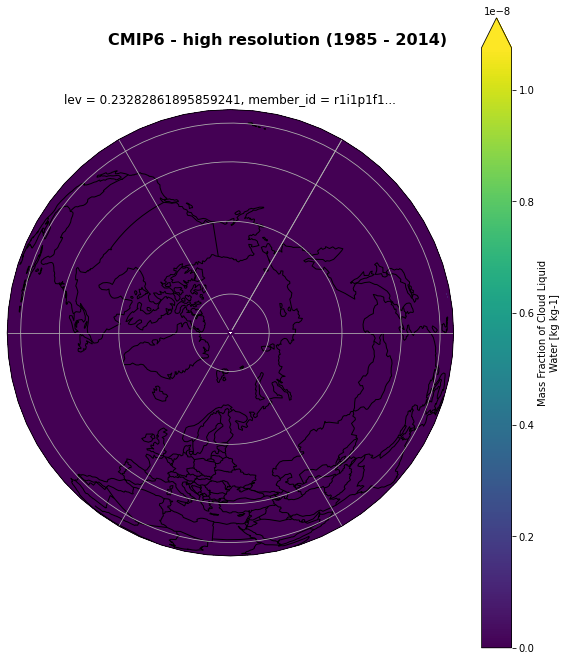

In [26]:
fig, ax = plt.subplots(1,1, 
                         figsize=[10,10], 
                         subplot_kw={'projection':ccrs.Orthographic(30, 90)})
fig.suptitle('CMIP6 - high resolution (1985 - 2014)', fontsize=16, fontweight="bold")

# Plot cosmetics 
ax.coastlines()
gl = ax.gridlines()
ax.add_feature(cy.feature.BORDERS);
gl.top_labels = False

im = _month.sel(month = 1).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar = True,extend = 'max')



plt.tight_layout()
fig.subplots_adjust(top=1)

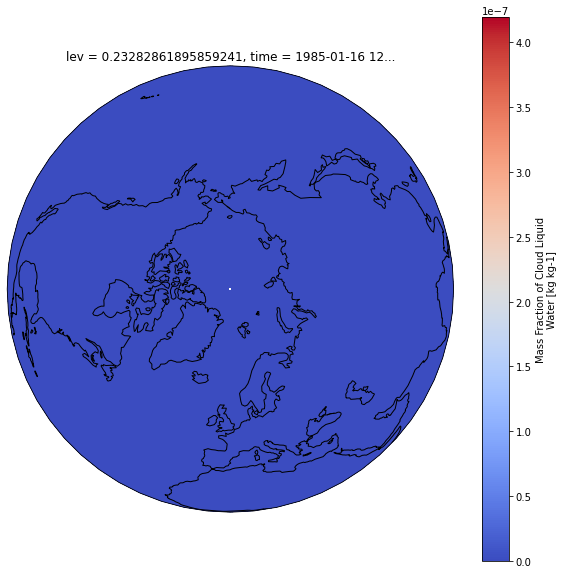

In [27]:
fig = plt.figure(1, figsize=[10,10])

ax = plt.subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()
if ds.lev.all() == True:
    ds[variable_id[0]].isel(lev=16).sel(time=cftime.DatetimeNoLeap(1985, 1, 16, 12, 0, 0, 0)).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')
else:
    ds[variable_id[0]].sel(time=cftime.DatetimeNoLeap(1985, 1, 16, 12, 0, 0, 0)).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')

### Get attributes (unique identifier)

In [28]:
ds.attrs['tracking_id']

'hdl:21.14100/1c8e58a1-c250-4120-9fb6-159885cd5a96\nhdl:21.14100/c1340042-4644-4d38-9270-d000d8d14b19\nhdl:21.14100/c7f9967e-a7a9-44ae-bbb5-4b5a02c5a7b3\nhdl:21.14100/34449e11-fad2-4fea-82c8-19e194f8d7f5\nhdl:21.14100/fd79dd4c-b2aa-4290-83a2-07dce463a1c0\nhdl:21.14100/b548a684-f49f-4dac-b1a9-acc24a8ff750\nhdl:21.14100/66f04c76-793d-4a11-bed4-040d3b0b7de5\nhdl:21.14100/8e53004f-a51b-4fcb-b4db-cafd3cb33de3\nhdl:21.14100/c0b36dc0-7408-462a-a3da-849bda149260\nhdl:21.14100/5410d0a1-9def-42b7-91a0-d959a6650d4a\nhdl:21.14100/23e3e9fd-2131-4952-b5eb-36f058178ab2\nhdl:21.14100/e2948317-3a1d-4627-822c-03ed8097c2ed\nhdl:21.14100/be8f947a-bf1e-4a2f-9320-e33d65ef2b6c\nhdl:21.14100/8c2c2821-597e-45f9-8990-ba520145b33c\nhdl:21.14100/1c1b0353-cd70-47e6-8c17-676783f1a93b\nhdl:21.14100/214acf85-5eb2-4924-b063-adc28c657692\nhdl:21.14100/11406d14-0f70-44f6-ae0d-6c246f1305e3'

# Regrid CMIP6 data to common NorESM2-MM grid

In [63]:
starty = 1985; endy = 2014
year_range = range(starty, endy+1)

# create dictionary for reggridded data
ds_gridded_dict = dict()

# Read in the output grid from NorESM
if variable_id[0] == 'lwp':
    ds_out = dset_dict['CMIP.NCC.NorESM2-MM.historical.AERmon.gn'].isel(member_id = 0)
else:
    ds_out = dset_dict['CMIP.NCC.NorESM2-MM.historical.Amon.gn'].isel(member_id = 0)
ds_out = ds_out.sel(time = ds_out.time.dt.year.isin(year_range)).squeeze()

# if ds_out.lev.all == True:
#     ds_out = ds_out.transpose

counter = 0

for keys in dset_dict.keys():
    # select only models which have atmospheric monthly values
    amon = keys.split('.')[-2]
    if amon == 'Amon' or amon == 'AERmon': 
        # select model name 
        model = keys.split('.')[2]
        
        # select where data should be saved
        filename = '{}_Amon_1deg_{}01_{}12.nc'.format(variable_id[0], starty, endy)
        savepath = '/scratch/franzihe/output/CMIP6_hist/1deg/{}/'.format(model)
        nc_out = savepath + filename
        files = glob(nc_out)
        
        
            
        # Input data from CMIP6 model to be regridded
        ds_in = dset_dict[keys].isel(member_id = 0)
        ds_in = ds_in.sel(time = ds_in.time.dt.year.isin(year_range)).squeeze()
            
        # common time grid
        ds_in['time'] = ds_out['time']
            
            
            
        # Regrid data
        ds_in_regrid = fct.regrid_data(ds_in, ds_out)
          
        # Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
        ds_in_regrid = ds_in_regrid.assign_coords(lon=(((ds_in_regrid.lon + 180) % 360) - 180)).sortby('lon').sortby('time')
        ds_in_regrid = ds_in_regrid.reset_coords(names=['time_bnds', ], drop=True)
            

            
        # create dataset with all models
        ds_gridded_dict[model] = ds_in_regrid
        # ds_in_regrid.close(); ds_in.close(); ds_out.close()

        if nc_out in files:
            print('{} is downloaded'.format(nc_out))
            counter += 1
            print('Have regridded in total: {:} files'.format(str(counter)))
        else:    
            # Save to netcdf file
            ds_in_regrid.to_netcdf(nc_out)
            print('file written: {}'.format(nc_out))

Overwrite existing file: bilinear_192x288_192x288.nc 
 You can set reuse_weights=True to save computing time.
Remove file bilinear_192x288_192x288.nc
using dimensions ('lev',) from data variable a as the horizontal dimensions for this dataset.


IndexError: list index out of range

In [ ]:
CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.Amon.gr
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn 160 320

In [79]:
# Regrid data
keys = 'CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.Amon.gr'
ds_in = dset_dict[keys].isel(member_id = 0)


# Interpolate from CMIP6 model levels to ERA5 pressure levels

In [110]:
era_pressure = np.array([   1,    2,    3,    5,    7,   10,   20,   30,   50,   70,  100,  125,
        150,  175,  200,  225,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  775,  800,  825,  850,  875,  900,  925,  950,  975,
       1000])

In [108]:
_ds = dset_dict['CMIP.NCC.NorESM2-MM.historical.Amon.gn']

In [115]:
array = Ngl.vinth2p(datai, hbcofa, hbcofb, plevo, 
                     psfc, intyp, p0, ii, kxtrp)


#  Extract the desired variables (need numpy arrays for vertical interpolation)
hbcofa = _ds["a"]
hbcofb = _ds["b"]
plevo  = era_pressure[0]
psfc   = _ds["ps"]
intyp  = 1            # 1=linear, 2=log, 3=log-log
p0     = _ds["p0"]
ii     = 1
kxtrp  = False        # True=extrapolate (when the output pressure level is outside of the range of psrf)

var    = _ds[variable_id[0]]

var_new = Ngl.vinth2p(var, hbcofa, hbcofb, plevo, psfc, intyp, p0, ii, kxtrp)

NameError: name 'Ngl' is not defined

In [84]:
if ds_in.ap.all() == True or ds_in.a.all() == True:
    

exists


In [ ]:
ds_in_regrid = fct.regrid_data(ds_in.drop_vars(['a', 'b', 'p0'] ), ds_out.drop_vars(['a', 'b', 'p0'] ))


In [70]:
ds_in_regrid.merge(ds_in, compat="override")

<xarray.Dataset>
Dimensions:    (time: 360, lev: 30, lat: 192, lon: 288, bnds: 2)
Coordinates:
    a_bnds     (lev, bnds) float64 dask.array<chunksize=(30, 2), meta=np.ndarray>
    b_bnds     (lev, bnds) float64 dask.array<chunksize=(30, 2), meta=np.ndarray>
  * lev        (lev) float64 0.9926 0.9763 0.9575 ... 0.01436 0.007595 0.003643
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(30, 2), meta=np.ndarray>
  * time       (time) object 1985-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
    member_id  <U8 'r1i1p1f1'
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    clw        (time, lev, lat, lon) float64 dask.array<chunksize=(15, 30, 192, 288), meta=np.ndarray>
    ps         (time, lat, lon) float64 dask.array<chunksize=(15, 192, 288), meta=np.ndarray>
    a          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    b          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    p0         float64 ...
Attributes: (12/55)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 0671-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     171550.0
    ...                        ...
    variable_id:               clw
    variant_label:             r1i1p1f1
    netcdf_tracking_ids:       hdl:21.14100/eaaf06d3-bbc0-426b-9fca-04981423a211
    version_id:                v20200623
    intake_esm_varname:        ['clw']
    intake_esm_dataset_key:    CMIP.AS-RCEC.TaiESM1.historical.Amon.gn

In [17]:
ds_gridded_dict.keys()

dict_keys(['NorESM2-MM', 'EC-Earth3-AerChem', 'GFDL-ESM4', 'TaiESM1'])

# Connect all models into one Dataset with new coordinate 'model'

In [18]:
_ds = list(ds_gridded_dict.values())
_coord = list(ds_gridded_dict.keys())
ds_cmip = xr.concat(objs=_ds, dim=_coord, coords="all").rename({'concat_dim':'model'})
ds_cmip = ds_cmip.drop('bnds')



In [20]:
if variable_id[0] == 'prsn':
    ds_cmip[variable_id[0]] = ds_cmip[variable_id[0]]*86400
    ds_cmip[variable_id[0]].attrs = {'units': 'mm day-1', 'long_name': 'Snowfall', 'comment': 'At surface; includes precipitation of all forms of water in the solid phase', 'cell_methods': 'area: time: mean', 'cell_measures': 'area: areacella'}
if variable_id[0]  == 'clivi':
    ds_cmip[variable_id[0]] = ds_cmip[variable_id[0]]*1000
    ds_cmip[variable_id[0]].attrs = {'units': 'g m-2', 'long_name': 'Ice Water Path', 'comment': 'mass of ice water in the column divided by the area of the column (not just the area of the cloudy portion of the column). Includes precipitating frozen hydrometeors ONLY if the precipitating hydrometeor affects the calculation of radiative transfer in model.', 'cell_methods': 'area: time: mean', 'cell_measures': 'area: areacella'}    
if variable_id[0] == 'lwp':
    ds_cmip[variable_id[0]] = ds_cmip[variable_id[0]]*1000
    ds_cmip[variable_id[0]].attrs = {'units': 'g m-2', 'long_name': 'Liquid Water Path', 'comment': 'The total mass of liquid water in cloud per unit area.', 'cell_methods': 'area: time: mean', 'cell_measures': 'area: areacella'}
if variable_id[0] == 'pr':
    ds_cmip[variable_id[0]] = ds_cmip[variable_id[0]]*86400
    ds_cmip[variable_id[0]].attrs = {'units': 'mm day-1', 'long_name': 'Precipitation', 'comment': 'includes both liquid and solid phases','cell_methods': 'area: time: mean', 'cell_measures': 'area: areacella'}

# Create seasonal mean of all regridded models
...and plot seasonal mean of each individual model

In [21]:
ds_cmip[variable_id[0]+'_season_mean'] = ds_cmip[variable_id[0]].groupby('time.season').mean('time', keep_attrs=True)

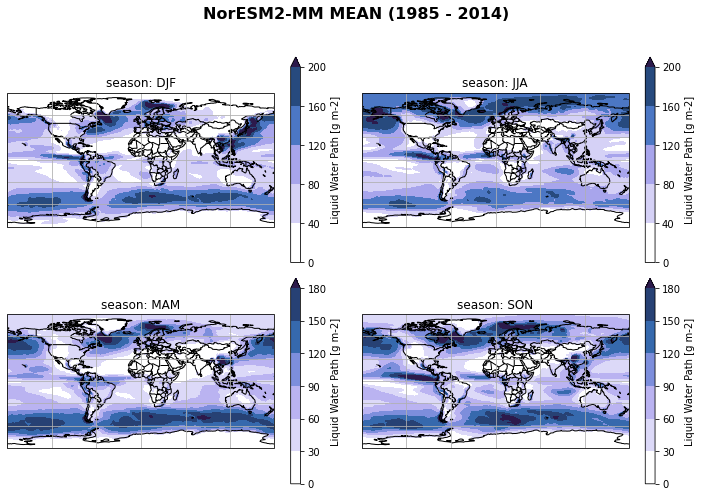

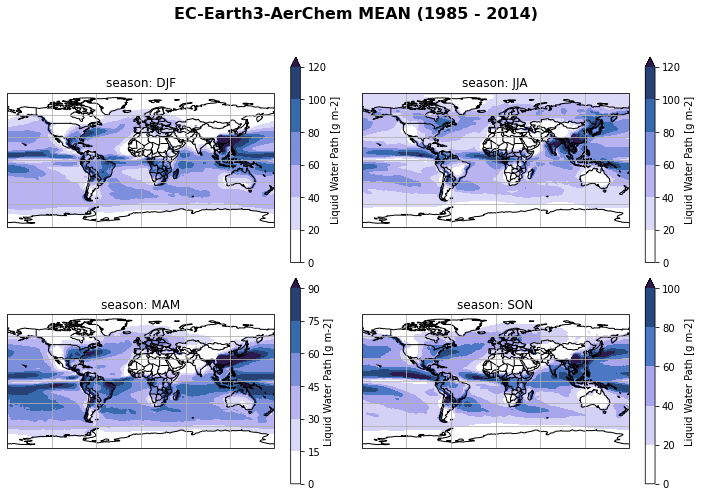

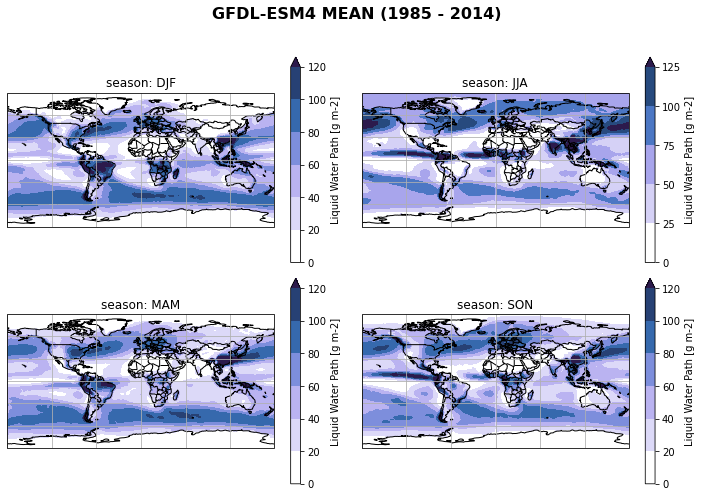

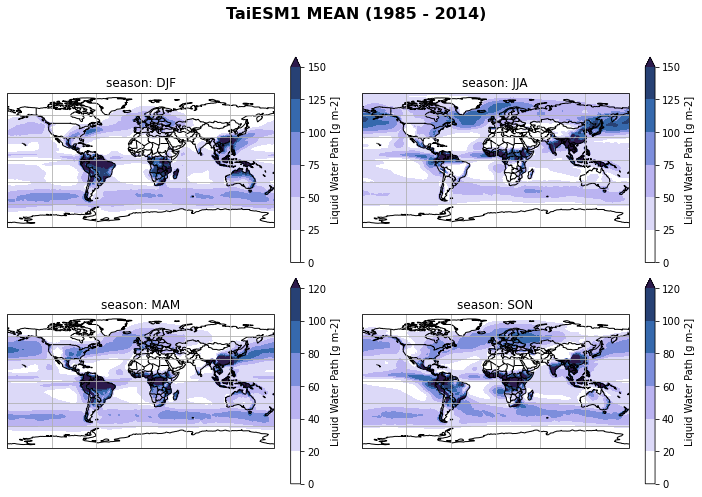

In [22]:
for model in ds_cmip.model.values:
    fct.plt_spatial_seasonal_mean(ds_cmip[variable_id[0]+'_season_mean'].sel(model=model), title='{} MEAN ({} - {})'.format(model,starty, endy))

# Create model mean/spread of seasonal mean of all regridded models

In [23]:
ds_cmip[variable_id[0]+'_season_model_mean'] = ds_cmip[variable_id[0]+'_season_mean'].mean('model', keep_attrs=True, skipna = True)
ds_cmip[variable_id[0]+'_season_model_std']  = ds_cmip[variable_id[0]+'_season_mean'].std('model', keep_attrs=True, skipna = True)

In [24]:
if variable_id[0] == 'prsn':
    label='Snowfall (mm$\,$day$^{-1}$)'
    vmin = 0
    vmax = 2.5
    levels = 25
    add_colorbar=False
    vmin_std = vmin
    vmax_std= 0.6
if variable_id[0] == 'pr':
    label='Total precipitation (mm$\,$day$^{-1}$)' 
    vmin = 0
    vmax=9
    levels = 90
    add_colorbar=False
    vmin_std =vmin
    vmax_std = 2.4
elif variable_id[0] == 'clivi':
    label='Ice Water Path (g$\,$m$^{-2}$)'
    vmin = 0
    vmax=100
    levels = 25
    add_colorbar = False
    vmin_std =vmin
    vmax_std = 20
elif variable_id[0] == 'lwp':
    label='Liquid Water Path (g$\,$m$^{-2}$)'
    vmin = 0
    vmax=100
    levels = 25
    add_colorbar = False
    vmin_std =vmin
    vmax_std = 20
elif variable_id[0] == 'tas':
    label='2-m temperature (K)'
    vmin = 246
    vmax=300
    levels = 40
    add_colorbar = False
    vmin_std = 0
    vmax_std=6
    

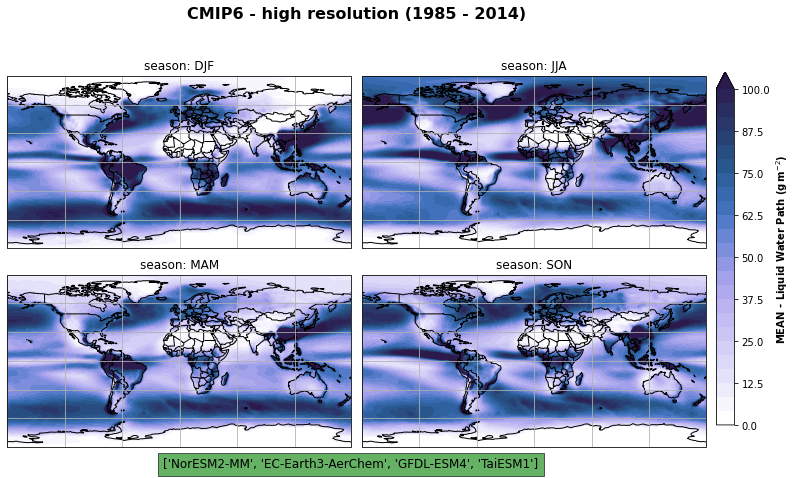

In [25]:
fig, axs, im = fct.plt_spatial_seasonal_mean(ds_cmip[variable_id[0]+'_season_model_mean'], vmin, vmax, levels, add_colorbar=False, title='CMIP6 - high resolution (1985 - 2014)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
cb.set_label(label='MEAN - {}'.format(label), weight='bold')

plt.tight_layout()


axs[2].text(1,-0.12, ds_cmip.model.values.tolist()[0:5], size=12, ha="center", 
         transform=axs[2].transAxes, bbox ={'facecolor':'green',
                'alpha':0.6,
                'pad':5})
if len(ds_cmip.model.values.tolist()) > 4:
    axs[2].text(1,-0.25, ds_cmip.model.values.tolist()[5:10], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
if len(ds_cmip.model.values.tolist()) > 10:
    axs[2].text(1,-0.38, ds_cmip.model.values.tolist()[10:-1], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
    

# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/CMIP6/'
figname = '{}_season_mean_1deg_{}_{}.png'.format(variable_id[0], starty, endy)
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)

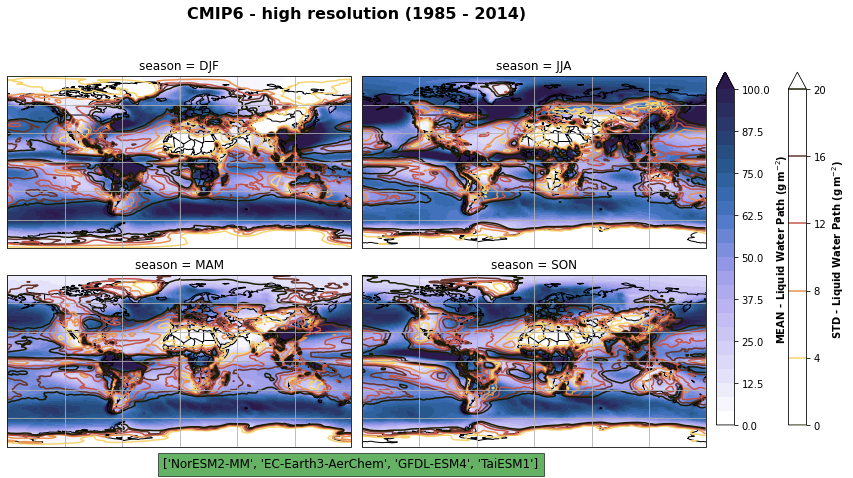

In [26]:
fig, axs, im = fct.plt_spatial_seasonal_mean(ds_cmip[variable_id[0]+'_season_model_mean'], vmin, vmax, levels, add_colorbar=False, title='CMIP6 - high resolution (1985 - 2014)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
cb.set_label(label='MEAN - {}'.format(label), weight='bold')



for ax, i in zip(axs, ds_cmip[variable_id[0]+'_season_model_std'].season):
    sm = ds_cmip[variable_id[0]+'_season_model_std'].sel(season=i).plot.contour(ax=ax, transform=ccrs.PlateCarree(), 
                                                                      robust=True,
                                                                      vmin = vmin_std, vmax = vmax_std,
                                                                       levels = 6,
                                                                      cmap=cm.lajolla,
                                                                      add_colorbar=False)
    
cbar_ax = fig.add_axes([1.10, 0.15, 0.025, 0.7])
sb = fig.colorbar(sm, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
sb.set_label(label='STD - {}'.format(label), weight='bold')


plt.tight_layout()


axs[2].text(1,-0.12, ds_cmip.model.values.tolist()[0:5], size=12, ha="center", 
         transform=axs[2].transAxes, bbox ={'facecolor':'green',
                'alpha':0.6,
                'pad':5})
if len(ds_cmip.model.values.tolist()) > 4:
    axs[2].text(1,-0.25, ds_cmip.model.values.tolist()[5:10], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
if len(ds_cmip.model.values.tolist()) > 10:
    axs[2].text(1,-0.38, ds_cmip.model.values.tolist()[10:-1], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/CMIP6/'
figname = '{}_season_mean_std_1deg_{}_{}.png'.format(variable_id[0], starty, endy)
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)

In [27]:
# savet to netcdf
filename = '{}_1deg_{}01_{}12.nc'.format(variable_id[0], starty, endy)
savepath = '/scratch/franzihe/output/CMIP6_hist/1deg/'
nc_out = savepath + filename
files = glob(nc_out)

counter = 0 
# Save to netcdf file
if nc_out in files:
#     print('{} is downloaded'.format(nc_out))
#     counter += 1
#     print('Have saved in total: {:} files'.format(str(counter)))
# else:
    ds_cmip.to_netcdf(nc_out)
    print('file written: .{}'.format(nc_out))

file written: ./scratch/franzihe/output/CMIP6_hist/1deg/lwp_1deg_198501_201412.nc
